In [5]:
import numpy as np
import pandas as pd 
import os
import sys

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from IPython.display import Audio

import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

2025-08-24 21:10:11.299457: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756069811.530926      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756069811.597161      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [6]:
Crema = "/kaggle/input/cremad/AudioWAV/"

In [7]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()

,Emotions,Path
0,disgust,/kaggle/input/cremad/AudioWAV/1028_TSI_DIS_XX.wav
1,happy,/kaggle/input/cremad/AudioWAV/1075_IEO_HAP_LO.wav
2,happy,/kaggle/input/cremad/AudioWAV/1084_ITS_HAP_XX.wav
3,disgust,/kaggle/input/cremad/AudioWAV/1067_IWW_DIS_XX.wav
4,disgust,/kaggle/input/cremad/AudioWAV/1066_TIE_DIS_XX.wav


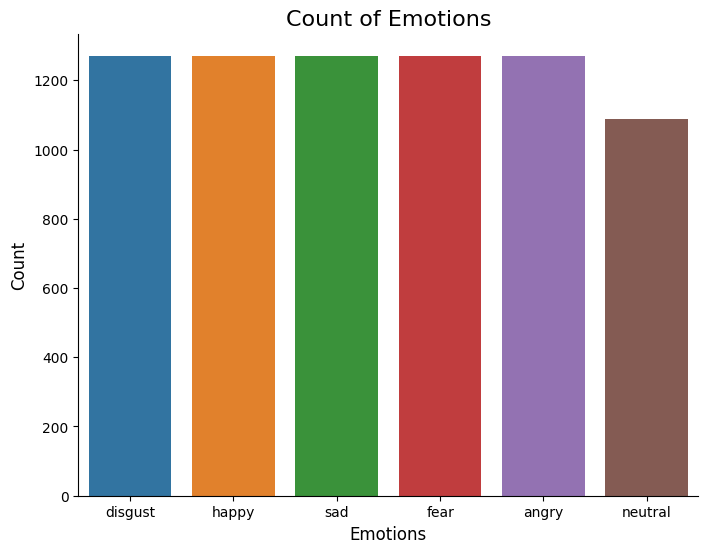

In [9]:
plt.figure(figsize=(8,6))
sns.countplot(x="Emotions", data=Crema_df, order=Crema_df['Emotions'].value_counts().index)
plt.title('Count of Emotions', size=16)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [10]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    plt.colorbar()

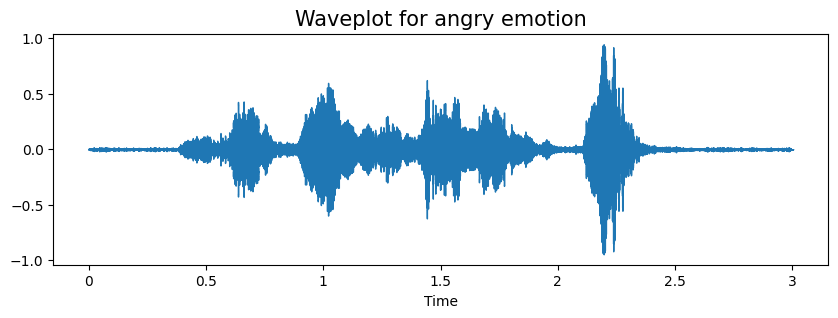

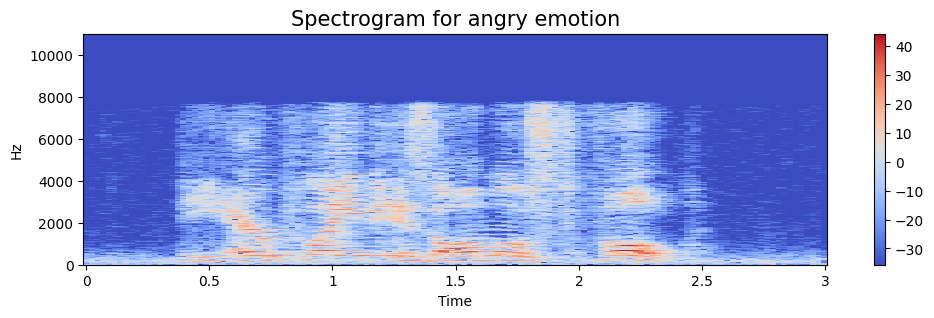

In [11]:
emotion='angry'
path = np.array(Crema_df.Path[Crema_df.Emotions==emotion])[0]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

In [12]:
labels = {'disgust':0,'happy':1,'sad':2,'neutral':3,'fear':4,'angry':5}
Crema_df.replace({'Emotions':labels},inplace=True)

In [13]:
# dataframe for paths of files
path_df = pd.DataFrame(file_path, columns=['Path'])

# combine both → final dataframe
Crema_df = pd.concat([emotion_df, path_df], axis=1)

print(Crema_df.head())
print("Total files:", len(Crema_df))

  Emotions                                               Path
0  disgust  /kaggle/input/cremad/AudioWAV/1028_TSI_DIS_XX.wav
1    happy  /kaggle/input/cremad/AudioWAV/1075_IEO_HAP_LO.wav
2    happy  /kaggle/input/cremad/AudioWAV/1084_ITS_HAP_XX.wav
3  disgust  /kaggle/input/cremad/AudioWAV/1067_IWW_DIS_XX.wav
4  disgust  /kaggle/input/cremad/AudioWAV/1066_TIE_DIS_XX.wav
Total files: 7442


In [15]:
num_mfcc = 40
n_fft = 2048
hop_length = 512
SAMPLE_RATE = 22050

data = {
    "labels": [],
    "features": []
}

for i in range(len(Crema_df)):
    data['labels'].append(Crema_df.iloc[i,0])
    
    # Load audio
    signal, sample_rate = librosa.load(Crema_df.iloc[i,1], sr=SAMPLE_RATE)
    
    # MFCC + Delta + Delta-Delta
    mfcc = librosa.feature.mfcc(
        y=signal, sr=sample_rate, n_mfcc=num_mfcc, 
        n_fft=n_fft, hop_length=hop_length
    )
    delta = librosa.feature.delta(mfcc)
    delta2 = librosa.feature.delta(mfcc, order=2)
    
    # Stack features → shape = (120, time_frames)
    feature = np.vstack([mfcc, delta, delta2])
    
    # Transpose → shape = (time_frames, 120)
    feature = feature.T
    
    # Append to dataset
    data["features"].append(np.asarray(feature))
    
    if i % 500 == 0:
        print(f"Processed {i} files")

print("✅ Feature extraction complete")


Processed 0 files
Processed 500 files
Processed 1000 files
Processed 1500 files
Processed 2000 files
Processed 2500 files
Processed 3000 files
Processed 3500 files
Processed 4000 files
Processed 4500 files
Processed 5000 files
Processed 5500 files
Processed 6000 files
Processed 6500 files
Processed 7000 files
✅ Feature extraction complete


In [16]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_LEN = 216  # based on dataset stats
X = pad_sequences(data["features"], maxlen=MAX_LEN, padding='post', dtype='float32')
y = np.array(data["labels"])

print(X.shape, y.shape)   # → (7442, 216, 120)


(7442, 216, 120) (7442,)


In [22]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_reshaped = X.reshape(-1, X.shape[2])
X_scaled = scaler.fit_transform(X_reshaped)
X = X_scaled.reshape(X.shape)


In [24]:
def augment_audio(signal, sr):
    if np.random.rand() < 0.5:
        signal = librosa.effects.pitch_shift(signal, sr, n_steps=np.random.randint(-2, 3))
    if np.random.rand() < 0.5:
        signal = librosa.effects.time_stretch(signal, rate=np.random.uniform(0.8, 1.2))
    return signal

In [23]:
# Map emotions to integers
label_map = {'disgust': 0, 'happy': 1, 'sad': 2, 'neutral': 3, 'fear': 4, 'angry': 5}
y = np.array([label_map[label] for label in data["labels"]])

# One-hot encode
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, num_classes=6)

print(y.shape)  # should be (7442, 6)


(7442, 6)


In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print(X_train.shape, X_val.shape, X_test.shape)


(5357, 216, 120) (1340, 216, 120) (745, 216, 120)


In [27]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization, Bidirectional, Attention, GlobalAveragePooling1D

# Input
inputs = Input(shape=(X.shape[1], X.shape[2]))

# CNN block
x = Conv1D(128, 5, activation='relu')(inputs)
x = BatchNormalization()(x)
x = MaxPooling1D(2)(x)
x = Dropout(0.3)(x)

# BiLSTM block
x = Bidirectional(LSTM(128, return_sequences=True))(x)
x = Bidirectional(LSTM(64, return_sequences=True))(x)

# Attention
attn_out = Attention()([x, x])   # query = value = x
x = GlobalAveragePooling1D()(attn_out)  # pool across time

# Dense layers
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(6, activation='softmax')(x)

# Build model
model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 216, 120)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 212, 128)  │     76,928 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 212, 128)  │        512 │ conv1d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_3     │ (None, 106, 128)  │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 106, 128)  │          0 │ max_pooling1d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_4     │ (None, 106, 256)  │    263,168 │ dropout_7[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_5     │ (None, 106, 128)  │    164,352 │ bidirectional_4[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_2         │ (None, 106, 128)  │          0 │ bidirectional_5[… │
│ (Attention)         │                   │            │ bidirectional_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ attention_2[0][0] │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 128)       │     16,512 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 128)       │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 6)         │        774 │ dropout_8[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 522,246 (1.99 MB)

 Trainable params: 521,990 (1.99 MB)

 Non-trainable params: 256 (1.00 KB)

In [28]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32
)

test_loss, test_acc = model.evaluate(X_test, y_test)
print("✅ Test Accuracy:", test_acc)


Epoch 1/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 80s 407ms/step - accuracy: 0.3627 - loss: 1.5477 - val_accuracy: 0.4485 - val_loss: 1.3366
Epoch 2/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 66s 390ms/step - accuracy: 0.4870 - loss: 1.2981 - val_accuracy: 0.4836 - val_loss: 1.2977
Epoch 3/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 66s 391ms/step - accuracy: 0.5396 - loss: 1.1831 - val_accuracy: 0.3485 - val_loss: 1.9571
Epoch 4/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 66s 392ms/step - accuracy: 0.5651 - loss: 1.1174 - val_accuracy: 0.5590 - val_loss: 1.1458
Epoch 5/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 65s 390ms/step - accuracy: 0.6358 - loss: 0.9981 - val_accuracy: 0.5873 - val_loss: 1.1494
Epoch 6/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 66s 391ms/step - accuracy: 0.6417 - loss: 0.9595 - val_accuracy: 0.5903 - val_loss: 1.1147
Epoch 7/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 65s 388ms/step - accuracy: 0.6612 - loss: 0.9081 - val_accuracy: 0.6269 - val_loss: 1.0456
Epoch 8/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 65s 389ms/step - accuracy: 0.6992 - loss: 0

In [29]:
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import numpy as np

# Predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# F1 scores
f1_macro = f1_score(y_true, y_pred_classes, average='macro')
f1_weighted = f1_score(y_true, y_pred_classes, average='weighted')

print("✅ F1 Macro:", f1_macro)
print("✅ F1 Weighted:", f1_weighted)

# Detailed classification report
print("\nClassification Report:\n", classification_report(y_true, y_pred_classes, target_names=list(label_map.keys())))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
print("\nConfusion Matrix:\n", cm)

24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 156ms/step
✅ F1 Macro: 0.588265482052903
✅ F1 Weighted: 0.5909143064580064

Classification Report:
               precision    recall  f1-score   support

     disgust       0.59      0.51      0.55       128
       happy       0.58      0.49      0.53       125
         sad       0.53      0.60      0.56       119
     neutral       0.64      0.65      0.64       113
        fear       0.60      0.43      0.50       121
       angry       0.64      0.90      0.75       139

    accuracy                           0.60       745
   macro avg       0.60      0.59      0.59       745
weighted avg       0.60      0.60      0.59       745


Confusion Matrix:
 [[ 65   9  17   5   7  25]
 [  6  61   1  12  13  32]
 [ 15   5  71  17  11   0]
 [ 11   5  12  73   2  10]
 [ 11  15  33   7  52   3]
 [  2  10   0   0   2 125]]
